<a href="https://colab.research.google.com/github/Nickmescher/ml5sem/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Деревья решений

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$. 
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки. 
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вкршину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$

## Функционал качества для деревьев решений


Энтропия Шеннона для системы с N возможными состояниями определяется по формуле:
$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

где $p_i$ – вероятности нахождения системы в $i$-ом состоянии. 

Это очень важное понятие теории информации, которое позволяет оценить количество информации (степень хаоса в системе). Чем выше энтропия, тем менее упорядочена система и наоборот. С помощью энтропии мы формализуем функционал качества для разделение выборки (для задачи классификации).

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import random
from pprint import pprint

Код для расчёта энтропии:

In [ ]:
def entropy(y):
    
    _, counts = np.unique(y, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

Здесь $y$ - это массив значений целевой переменной

Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, так можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер. 

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


### Задание 4.1

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения дерева (используйте `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признакоd и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три из разными критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

Реализуйте функцию `predict` (на вход функции подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики доля правильных ответов (`from sklearn.metrics import accuracy_score` или реализовать свою).

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

In [ ]:
class Node():
    
    def __init__(self, feature=0, threshold=0, labels=None, left=None, right=None):
        self.feature = feature
        self.threshold = threshold
        self.labels = labels
        self.left = left
        self.right = right

In [ ]:
class DecisionTree():

    def __init__(self, stop_parameter, parameter_value):
        self.stop_parameter = stop_parameter
        self.parameter_value = parameter_value

    def information_gain(self, node, left, right):
        n_node = node.shape[0]
        try:
            return entropy(node) - left.shape[0] / n_node * entropy(left) - right.shape[0] / n_node * entropy(right)
        except ZeroDivisionError:
            return 0
    
    def best_split(self, X, y):
        best_feature = None
        best_threshold = None
        highest_q_value = 0
        for feature in range(X.shape[1]):
            thresholds = np.linspace(X[:, feature].min(), X[:, feature].max(), 10)
            q_values = np.array([self.information_gain(y, y[X[:, feature] < threshold], y[X[:, feature] >= threshold])
                                 for threshold in thresholds])
            max_q_value = q_values.max()
            if highest_q_value < max_q_value:
                best_feature = feature
                best_threshold = thresholds[q_values.argmax()]
                highest_q_value = max_q_value
        return best_feature, best_threshold
            
    
    def split(self, X, y, feature, threshold):
        mask = X[:, feature] < threshold
        return X[mask, :], y[mask], X[~mask, :], y[~mask]
        

    def build_tree(self, X, y, parameter_value):
        # max_depth
        if self.stop_parameter == 'max_depth' and parameter_value:
            best_feature, best_threshold = self.best_split(X, y)
            if best_feature is not None:
                X_left, y_left, X_right, y_right = self.split(X, y, best_feature, best_threshold)
                return Node(feature=best_feature, threshold=best_threshold,
                            left=self.build_tree(X_left, y_left, parameter_value=parameter_value-1),
                            right=self.build_tree(X_right, y_right, parameter_value=parameter_value-1))
            else:
                return Node(labels=y)
        # purity
        elif self.stop_parameter == 'purity':
            best_feature, best_threshold = self.best_split(X, y)
            if best_feature is not None:
                X_left, y_left, X_right, y_right = self.split(X, y, best_feature, best_threshold)
                return Node(feature=best_feature, threshold=best_threshold,
                            left=self.build_tree(X_left, y_left, parameter_value),
                            right=self.build_tree(X_right, y_right, parameter_value))
            else:
                return Node(labels=y)
        # min_samples_leaf
        elif self.stop_parameter == 'min_samples_leaf' and parameter_value:
            best_feature, best_threshold = self.best_split(X, y)
            if best_feature:
                X_left, y_left, X_right, y_right = self.split(X, y, best_feature, best_threshold)
                if X_left.shape[0] >= parameter_value and X_right.shape[0] >= parameter_value:
                    return Node(feature=best_feature, threshold=best_threshold,
                         left=self.build_tree(X_left, y_left, parameter_value),
                         right=self.build_tree(X_right, y_right, parameter_value))
                else:
                    return Node(labels=y)
            else:
                return Node(labels=y)
        else:
            return Node(labels=y)

    def fit(self, X, y):
        self.root = self.build_tree(X, y, self.parameter_value)
        return self
    
    def predict(self, X):
        predictions = []
        labels_lens = []
        for x in X:
            node = self.root
            while node.labels is None: # while is not a leaf
                if x[node.feature] < node.threshold:
                    node = node.left
                else:
                    node = node.right
            predictions.append(np.bincount(node.labels).argmax())
        return np.array(predictions)

In [ ]:
from sklearn.metrics import accuracy_score
dt = DecisionTree(stop_parameter='min_samples_leaf', parameter_value=5).fit(X_train, y_train)
print('min_samples_leaf = 5; accuracy_score = ', accuracy_score(y_test, dt.predict(X_test)))
dt = DecisionTree(stop_parameter='purity', parameter_value=True).fit(X_train, y_train)
print('purity; accuracy_score = ', accuracy_score(y_test, dt.predict(X_test)))
dt = DecisionTree(stop_parameter='max_depth', parameter_value=5).fit(X_train, y_train)
print('max_depth = 5; accuracy_score = ', accuracy_score(y_test, dt.predict(X_test)))

min_samples_leaf = 5; accuracy_score =  0.98
purity; accuracy_score =  0.98
max_depth = 5; accuracy_score =  0.96


In [ ]:
from sklearn.tree import DecisionTreeClassifier
skReal = DecisionTreeClassifier(min_samples_leaf = 5, max_depth = 5, max_leaf_nodes = 5, criterion='entropy').fit(X_train, y_train)
print('Sklearn ',accuracy_score(y_test, skReal.predict(X_test)))

Sklearn  1.0


In [ ]:
y_test1 = y_test
y_test1_predict = dt.predict(X_test)

In [ ]:
#Sklearn реализация показывает результат примерно на 0.2 лучше

In [ ]:
# Из данных выше можем сделать вывод, что большая точность достигается при использовании
# критериев остановки: минимальное количество листьев в дереве и purity, а наименьшая из представленных
# при использовании критерия максимальная глубина дерева

##  Случайный лес

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


### Задание 4.2

В качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализйте алгоритм "случайный лес". 

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества, минимальное количество объектов в листьях и другие.

Нельзя использовать готовую реализацию случайного леса из `sklearn`.

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/churn.csv', index_col=0)
df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1


In [ ]:
# проверка на отстутсвующие значения
df.isnull().values.any()

False

In [ ]:
# проверка на дубликаты
df.duplicated().any()

False

In [ ]:
df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
df[['Geography', 'Gender']] = df[['Geography', 'Gender']].apply(LabelEncoder().fit_transform)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,0,0,42,2,0.00,1,1,1,101348.88,1
2,608,2,0,41,1,83807.86,1,0,1,112542.58,0
3,502,0,0,42,8,159660.80,3,1,0,113931.57,1
4,699,0,0,39,1,0.00,2,0,0,93826.63,0
5,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Exited'], axis=1),
                                                    df['Exited'],
                                                    test_size=0.33,
                                                    random_state=42)

In [ ]:
from sklearn.base import BaseEstimator
class RandomForest(BaseEstimator):
    def __init__(self, n_estimators=5, max_depth=5, criterion='entropy', min_samples_leaf=5, random_state=17):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.criterion = criterion
        self.min_samples_leaf = min_samples_leaf
        self.trees = []
        self.features_ids = []
        
    def fit(self, X, y):
        n_features = X.shape[1] // 2
        for n_estimator in range(self.n_estimators):
            np.random.seed(self.random_state + n_estimator)
            dt = DecisionTreeClassifier(max_depth=self.max_depth,
                                        max_features=n_features,
                                        random_state=self.random_state,
                                        min_samples_leaf=self.min_samples_leaf,
                                        criterion=self.criterion)
            rows_ids = np.random.choice(range(X.shape[0]), X.shape[0])
            columns_ids = np.random.choice(range(X.shape[1]), n_features, replace=False)
            X = pd.DataFrame(X)
            y = pd.DataFrame(y)
            dt.fit(X.iloc[rows_ids, columns_ids], y.iloc[rows_ids])
            self.trees.append(dt)
            self.features_ids.append(columns_ids)
        return self
    
    def predict(self, X):
        X = pd.DataFrame(X)
        predictions = []
        for x_id in range(X.shape[0]):
            single_predictions = [self.trees[n_tree].predict([X.iloc[x_id, self.features_ids[n_tree]]])[0]
                                  for n_tree in range(len(self.trees))]
            predictions.append(np.bincount(single_predictions).argmax())
        return predictions

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
rf = RandomForest(5, 5, 'entropy', 5).fit(X_train, y_train)
print('Random parameters accuracy_score = ', accuracy_score(y_test, rf.predict(X_test)))

Random parameters accuracy_score =  0.8133333333333334


In [ ]:
rf_params = {'n_estimators': list(range(5, 25)),
             'max_depth': list(range(5, 15)),
             'criterion': ['gini', 'entropy'],
             'min_samples_leaf': list(range(3, 16))}
rf_gridsearch = GridSearchCV(RandomForest(), rf_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=True)
rf_gridsearch.fit(X_train, y_train)
rf_gridsearch.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


{'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_leaf': 15,
 'n_estimators': 20}

In [ ]:
# наилучшие гиперпараметры этого алгоритма

In [ ]:
rf = RandomForest(20, 8, 'entropy', 15).fit(X_train, y_train)
print('Tuned parameters accuracy_score = ', accuracy_score(y_test, rf.predict(X_test)))

Tuned parameters accuracy_score =  0.8333333333333334


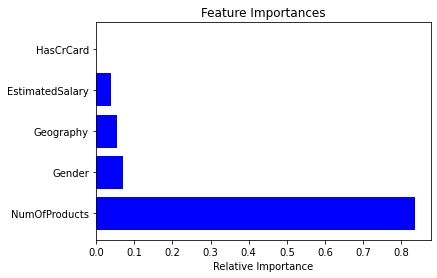

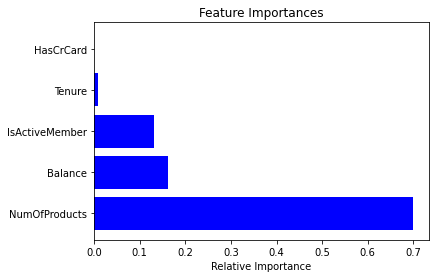

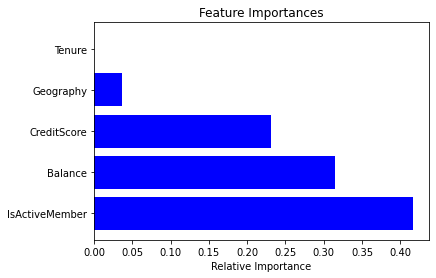

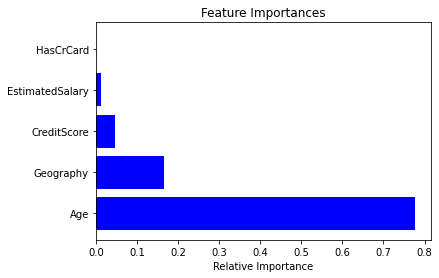

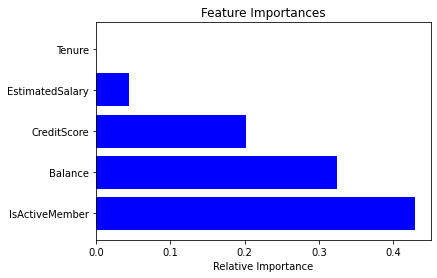

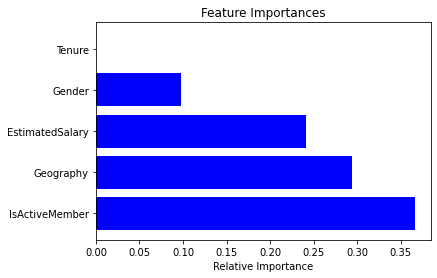

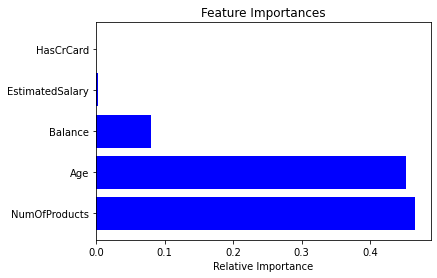

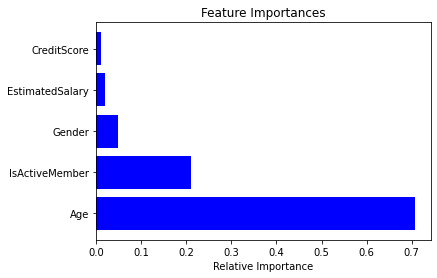

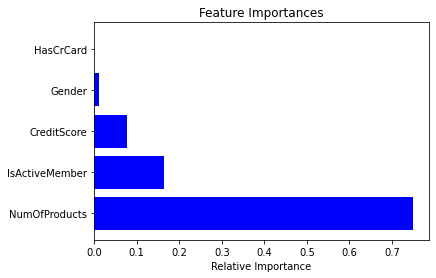

In [ ]:
# значимость признаков для каждого дерева
for n in range(len(rf.trees)):
    feature_importances = rf.trees[n].feature_importances_
    indices = np.argsort(feature_importances)[::-1]
    feature_importances = np.sort(feature_importances)[::-1]
    features = [rf.features_ids[n][index] for index in indices]
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), feature_importances, color='b', align='center')
    plt.yticks(range(len(indices)), df.columns[features])
    plt.xlabel('Relative Importance')
    plt.show()

In [ ]:
# Проанализировав значимость признаков по каждому дереву леса, можем сделать вывод, что наиболее важными призаками являются 
# NumofProducts, Age, следующими по важности идут IsActiveMember, Balance. Наименьшую важность имеют признаки: Tenure, HasCrCard.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
skForest = RandomForestClassifier(n_estimators=20, criterion='entropy', max_depth=8, min_samples_leaf=15)
skForest.fit(X_train, y_train)

y_pred = skForest.predict(X_test)
accuracy_score(y_test, y_pred)  

0.8693939393939394

In [ ]:
#Sklearn реализация работает примерно на 0.03 лучше чем моя

In [ ]:
# Матрица неточностей для задания выше 4.2

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_test_predict = rf.predict(X_test)

In [ ]:
print("Sklearn confusion matrix tree : \n", confusion_matrix(y_test, y_test_predict),"\n")

Sklearn confusion matrix tree : 
 [[2570   87]
 [ 618   25]] 



In [ ]:
def my_confusion_matrix(y_test, y_test_predict):
    tp = 0
    for yt, yp in zip(y_test, y_test_predict):
        if yt == 1 and yp == 1:
            tp +=1
    tn = 0
    for yt, yp in zip(y_test, y_test_predict):
        if yt == 0 and yp == 0:
            tn +=1

    fp = 0
    for yt, yp in zip(y_test, y_test_predict):
        if yt == 0 and yp == 1:
            fp +=1

    fn = 0
    for yt, yp in zip(y_test, y_test_predict):
        if yt == 1 and yp == 0:
            fn +=1
    return([[tn, fp], [fn, tp]])


In [ ]:
print("My confusion matrix tree : \n", my_confusion_matrix(y_test, y_test_predict))

My confusion matrix tree : 
 [[2570, 87], [618, 25]]


In [ ]:
# Сравнив мою реализацию матрицы неточностей с матрицей от sklearn можем убедиться в её правильности

In [ ]:
# Матрица неточностей для задания 4.1

In [ ]:
print("Sklearn confusion matrix tree : \n", confusion_matrix(y_test1, y_test1_predict, labels=[0, 1, 2]),"\n")

Sklearn confusion matrix tree : 
 [[19  0  0]
 [ 0 15  0]
 [ 0  2 14]] 



In [ ]:
def my_confusion_matrix1(y_test, y_test_predict):
    l0l0 = 0
    for yt, yp in zip(y_test, y_test_predict):
        if yt == 0 and yp == 0:
            l0l0 +=1
    l0l1 = 0
    for yt, yp in zip(y_test, y_test_predict):
        if yt == 0 and yp == 1:
            l0l1 +=1

    l0l2 = 0
    for yt, yp in zip(y_test, y_test_predict):
        if yt == 0 and yp == 2:
            l0l2 +=1

    l1l0 = 0
    for yt, yp in zip(y_test, y_test_predict):
        if yt == 1 and yp == 0:
            l1l0 +=1
    
    l1l1 = 0
    for yt, yp in zip(y_test, y_test_predict):
        if yt == 1 and yp == 1:
            l1l1 +=1

    l1l2 = 0
    for yt, yp in zip(y_test, y_test_predict):
        if yt == 1 and yp == 2:
            l1l2 +=1

    l2l0 = 0
    for yt, yp in zip(y_test, y_test_predict):
        if yt == 2 and yp == 0:
            l2l0 +=1

    l2l1 = 0
    for yt, yp in zip(y_test, y_test_predict):
        if yt == 2 and yp == 1:
            l2l1 +=1

    l2l2 = 0
    for yt, yp in zip(y_test, y_test_predict):
        if yt == 2 and yp == 2:
            l2l2 +=1
    return([[l0l0, l0l1, l0l2], [l1l0, l1l1, l1l2], [l2l0, l2l1, l2l2]])

In [ ]:
print("My confusion matrix tree : \n", my_confusion_matrix1(y_test1, y_test1_predict))

My confusion matrix tree : 
 [[19, 0, 0], [0, 15, 0], [0, 2, 14]]


In [ ]:
# Результат моей матрицы неточностей совпадает с результатом от sklearn, что позволяет говорить о её правильности

In [ ]:
# В первом задании ложно положительных и ложно отрицательных элементов у нас очень мало, 
# поэтому точность очень близка к единице, а во втором их уже намного больше, поэтому точность падает до порядка 0.8
# Так как при расчёте accuracy мы пользуемся формулой (tp + tn) / (tp + tn + fp + fn)
# Соответственно при большем количестве ложных элементов уменьшается точность